In [1]:
!pip install ISLP

In [2]:
import numpy as np
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from ISLP.models import poly, sklearn_sm
from sklearn.model_selection import train_test_split, cross_validate, KFold
import statsmodels.api as sm

## Part 1: Cross-Validation (Lab 5.3 in the Textbook)

Let's implement and compare the validation set approach to cross-validation. We will use the `Auto` dataset provided by the textbook authors. The objective to predict a car's fuel effiency (`mpg`) from some of its attributes. See the documentation for details: https://islp.readthedocs.io/en/latest/datasets/Auto.html.

In [3]:
Auto = load_data('Auto')
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


### The Validation Set Approach

Recall that the validation set approach consists of randomly splitting the available data into *training* and *validation* sets. Thankfully for us, the scikit-learn library (`sklearn`) provides us with an easy way of doing this.

In [4]:
Auto_train, Auto_valid = train_test_split(Auto,
                                          test_size=196,
                                          random_state=0) # random_state is the seed

Let's focus only on the `horsepower` predictor and fit a linear model on the training set.

In [5]:
# Construct design matrix
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']

#Fit OLS model
model = sm.OLS(y_train, X_train)
results = model.fit()

We can use the `predict` functionality we saw last week to compute the MSE on the validation set.

In [6]:
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results.predict(X_valid)
np.mean((y_valid-valid_pred)**2) # Validation set MSE

23.61661706966988

To avoid the annoyance of rewriting this for every model we wish to consider, we write a function which takes a list of covariates, a response, a training set, and a test/validation set, and then outputs the test/validation MSE.

In [7]:
def evalMSE(terms, response, train, test):
  mm = MS(terms)
  X_train = mm.fit_transform(train)
  y_train = train[response]
  X_test = mm.transform(test)
  y_test = test[response]

  results = sm.OLS(y_train, X_train).fit()
  test_pred = results.predict(X_test)

  return np.mean((y_test - test_pred)**2)

Using the `poly` function provided by the textbook authors, we can easily perform this validation for polynomial models.

e.g. When `degree` is 2, the `poly` function ensures we have two columns in the design matrix: `horsepower` and `horsepower**2`.

In [8]:
MSE = np.zeros(3)

for idx, degree in enumerate(range(1,4)):
  MSE[idx] = evalMSE([poly('horsepower', degree)],
                     'mpg',
                     Auto_train,
                     Auto_valid)
MSE

array([23.61661707, 18.76303135, 18.79694163])

Let's change the random seed so that we end up with a different random split into training and validation sets. Does the result change? What does this say about a drawback of the validation set method?

In [9]:
Auto_train, Auto_valid = train_test_split(Auto,
                                          test_size=196,
                                          random_state=3)
MSE = np.zeros(3)

for idx, degree in enumerate(range(1,4)):
  MSE[idx] = evalMSE([poly('horsepower', degree)],
                     'mpg',
                     Auto_train,
                     Auto_valid)
MSE

array([20.75540796, 16.94510676, 16.97437833])

### Cross-Validation

Recall that cross-validation consists of splitting the available data into "folds". One fold is held for testing and the rest are used for training. We then change which fold is used for testing and repeat the process.

The `sklearn` library provides cross-validation functionality with the `cross_validate` function. The authors of the textbook have a convenient `sklearn_sm` wrapper function which allows for the seamless use of `statsmodels` objects as arguments to `sklearn` functions.

The `cv` argument in `cross_validate` denotes the number of folds. In our first example, we take this to be $n$ (i.e., we perform leave-one-out CV).

In [10]:
hp_model = sklearn_sm(sm.OLS,
                      MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

24.23151351792922

Let's use leave-one-out cross-validation to compare polynomial models up to degree five. Notice the convenient shorthand used to create the design matrix.

In [11]:
#%%timeit # Uncomment this line at your peril to measure how fast this cell runs
cv_error = np.zeros(5)
H = np.array(Auto['horsepower'])
M = sklearn_sm(sm.OLS)

for i,d in enumerate(range(1,6)):
  X = np.power.outer(H, np.arange(d+1)) # Makes a matrix where the jth column is H^j
  M_CV = cross_validate(M,
                        X,
                        Y,
                        cv=Auto.shape[0])
  cv_error[i] = np.mean(M_CV['test_score'])

cv_error

array([24.23151352, 19.24821312, 19.33498406, 19.42443029, 19.03320648])

Now compare the compare to 10-fold cross-validation.

In [12]:
#%%timeit # Uncomment this line to measure how fast this cell runs
cv_error = np.zeros(5)
cv = KFold(n_splits=10,
           shuffle=True,
           random_state=0)
for i, d in enumerate(range(1,6)):
  X = np.power.outer(H, np.arange(d+1))
  M_CV = cross_validate(M,
                        X,
                        Y,
                        cv=cv)
  cv_error[i] = np.mean(M_CV['test_score'])

cv_error

array([24.20766449, 19.18533142, 19.27626666, 19.47848403, 19.13720065])

Notice that 10-fold cross validation runs *much* faster than leave-one-out cross-validation.

## Part 2: Subset Selection (Lab 6.5 in the Textbook)

Let's import some additional libraries that we will need for this part.

In [13]:
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from functools import partial

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
  (Stepwise ,
  sklearn_selected ,
  sklearn_selection_path)
!pip install l0bnb
from l0bnb import fit_path

For this section, we will play some Moneyball. We use the `Hitters` dataset to predict the salary of a baseball player based on their performance in the previous year. Let's load and clean up the data.

In [15]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum() # Uh-oh! 59 salaries are missing

59

In [16]:
Hitters = Hitters.dropna();
Hitters.shape

(263, 20)

We have 20 predictors in this dataset. Are all of these relevant? Let's apply forward selection, which is conveniently implemented in the `sklearn` library.

### Forward Selection with $C_p$

Recall Mallow's $C_p$ statistic:
$$C_p(\hat{f}) = \frac{1}{n} \mathrm{RSS}(\hat{f}) + \frac{2p\hat{\sigma}^2}{n}.$$
Let's write a function to compute this since it is not implemented in the `sklearn` library.

Since the forward selection functionality in `sklearn` tries to maximize whatever score we give it, we will actually be writing a function to compute the negative $C_p$ statistic.

In [17]:
# Negative Cp statistic
def nCp(sigma2, estimator, X, Y):
  n, p = X.shape
  Yhat = estimator.predict(X)
  RSS = np.sum((Y-Yhat)**2)
  return -(RSS + 2 * p * sigma2) / n

Let's fit a linear model on all of the variables to start off with. Recall that we need an estimate $\hat{\sigma}^2$ of the true error variance $\sigma^2$. We can obtain this directly from our least squares estimator `OLS` in `statsmodels`.

In [18]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

Now, we redefine our negative $C_p$ function so that the `sigma2` is fixed to be our estimate of the error variance.

In [19]:
neg_Cp = partial(nCp,sigma2)

Next, we specify a search strategy using the object `Stepwise` in the `ISLP.models` package. The function `Stepwise.first_peak()` with `direction` set as `'forward'` runs forward selection until we are unable to add a variable that improves the score.

In [20]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

Now we feed our scoring function and our selection strategy into `sklearn`'s model selection function. We see that the selected model keeps ten of the predictors.

In [21]:
hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

Note that we can perform the same procedure but replace the score with negative AIC, negative BIC, or negative adjusted $R^2$. We leave this as an exercise.

We can also change `direction` to `'backward'` to perform backward selection.

### Forward Selection with Cross-Validation

Let's instead now focus on how we can combine cross-validation with forward selection. That is, instead of using a score like $C_p$, AIC, or BIC, we use the MSE (averaged over the $K$ folds) obtained from cross-validation.

The idea here is to generate a path from forward selection where variables are added one at a time based on which one produces the largest reduction in RSS. Then we compute the cross-validation MSE at each step on this path.

In [22]:
# Generating the path
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

In [23]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

We can plot the training MSE along this path. This is guaranteed to improve as we add more variables. This can be misleading, which is why we need to use cross-validation.

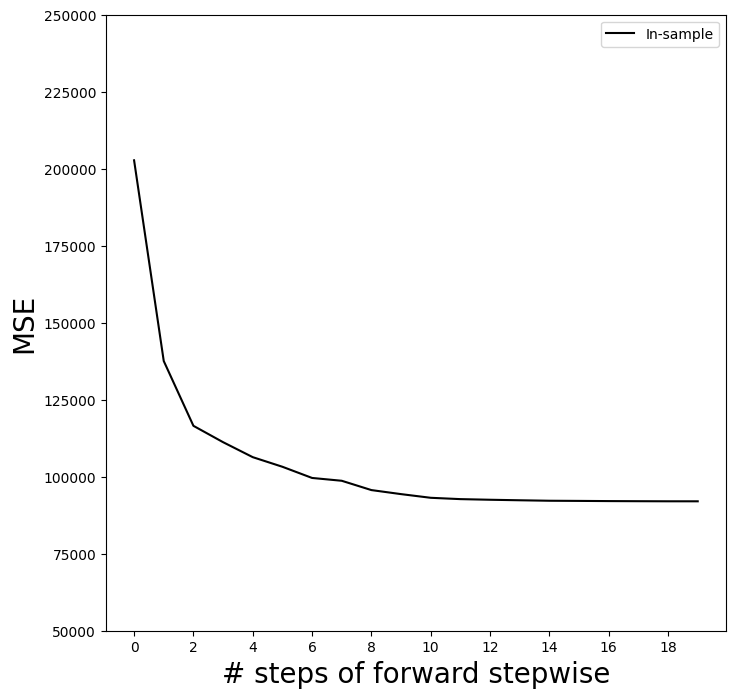

In [24]:
# We add a dimension (axis) to Y since Yhat_in is two-dimensional
mse_fig , ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse ,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim ([50000 ,250000]);

The next two cells perform cross-validation for each model along the path.

In [ ]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv=kfold)
Yhat_cv.shape

In [ ]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
  errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
  cv_mse.append(errors.mean(0))
cv_mse = np.array(cv_mse).T
cv_mse.shape

We obtain a cross-validation MSE for each of the five folds. We will now "cheat" a bit and take the average MSE across these five folds. This yields a crude estimate of the expected MSE since the training sets on each of the folds overlap.

We can then plot how our estimate of the expected MSE evolves as we add more variables. Note that unlike the in-sample MSE, it does not monotonically decrease.

In [ ]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r')
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

### Best Subset Selection

We use the `l0bnb` package to perform best subset selection. This library does not require that the intercept be specified in the design matrix, so we remove it.

In [ ]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

At each step, this package finds the best subset of variables subject to a penalty for including too many variables. This penalty softens as we take more steps. Notice this is different from finding the best subset of a *specific* size.

In [ ]:
path = fit_path(X, Y, max_nonzeros=X.shape[1])

Let's see what is chosen at the third step in the path. The fitted coefficients are stored in an array `B` (notice most of them are zero), the intercept is denoted `B0`. `lambda_0` and `M` are unimportant for us.

In [ ]:
path[3]

Moral of the story: Best subset selection is *very* slow.